In [1]:
import os
os.environ['XLA_PYTHON_CLIENT_PREALLOCATE'] = 'false'
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

from jax.config import config
config.update("jax_enable_x64", True)

import jax
import jax.numpy as jnp
import flax.linen as nn
from functools import partial
from models.SVAE_LDS import SVAE_LDS
from tqdm import trange
from train_utils import load_state, save_state, train_step, eval_step, create_dual_train_state, create_train_state
import numpy as np
import numpy.random as npr
from scipy.signal import sawtooth
import matplotlib.pyplot as plt
import pickle
import flax
from jax.config import config
from networks.layers import LayerNorm
from tensorflow_probability.substrates.jax import distributions as tfd
import optax 
import torch
from networks.dense import DenseNet
from networks.encoders import SigmaEncoder
from networks.decoders import SigmaDecoder
import tqdm

Let's start by generating a toy data set, as seen in [the original SVAE paper](https://proceedings.neurips.cc/paper/2016/file/7d6044e95a16761171b130dcb476a43e-Paper.pdf).

In [2]:
# Create data set
triangle = lambda t: sawtooth(np.pi*t, width=0.5)
make_dot_trajectory = lambda x0, v: lambda t: triangle(v*(t + (1+x0)/2.))
make_renderer = lambda grid, sigma: lambda x: np.exp(-1./2 * (x - grid)**2/sigma**2)

def make_dot_data(image_width, T, num_steps, x0=0.0, v=0.5, render_sigma=0.2, noise_sigma=0.1):
    grid = np.linspace(-1, 1, image_width, endpoint=True)
    render = make_renderer(grid, render_sigma)
    x = make_dot_trajectory(x0, v)
    images = np.vstack([render(x(t)) for t in np.linspace(0, T, num_steps)])
    return images + noise_sigma * npr.randn(*images.shape)
x = make_dot_data(10, 10, 50, x0=1.,v=0.75, render_sigma=0.15, noise_sigma=0.05)

np.random.seed(47)
N = 512
B = 16

inputs = []
for i in range(N):
    inputs.append(make_dot_data(10, 10, 50, x0=i/8, v=0.75, render_sigma=0.15, noise_sigma=0.06))

train_dset = np.stack(inputs)

inputs = []
for i in range(N):
    inputs.append(make_dot_data(10, 10, 50, x0=i/8, v=0.75, render_sigma=0.15, noise_sigma=0.06))

test_dset = np.stack(inputs)


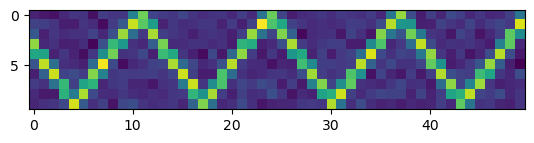

In [3]:
plt.imshow(train_dset[0].T)

In [4]:
# Set up data loading
torch.manual_seed(47)

train_dataloader = torch.utils.data.DataLoader(train_dset, batch_size = 32)
test_dataloader = torch.utils.data.DataLoader(train_dset, batch_size = 32)

process_batch = jnp.array
setup_batch = next(iter(train_dataloader))

In [5]:
cfg = lambda:0

# network hyperparameters
cfg.latent_D = 4
cfg.encoder_stage_sizes = [1, 1, 1]
cfg.encoder_hidden_sizes = [32, 32, 32]
cfg.decoder_stage_sizes = [1, 1, 1]
cfg.decoder_hidden_sizes = [32, 32, 32]

# Define networks
encoder_network = partial(DenseNet, resnet=True, 
                          stage_sizes=cfg.encoder_stage_sizes, 
                          hidden_sizes=cfg.encoder_hidden_sizes,
                          activation=nn.gelu,
                          norm_cls=LayerNorm)

decoder_network = partial(DenseNet, resnet=True, 
                          stage_sizes=cfg.decoder_stage_sizes, 
                          hidden_sizes=cfg.decoder_hidden_sizes,
                          activation=nn.gelu,
                          norm_cls=LayerNorm)
                          
encoder = partial(SigmaEncoder, network_cls=encoder_network)
decoder = partial(SigmaDecoder, network_cls=decoder_network, likelihood=tfd.Normal)

# Creat model
model_builder = partial(SVAE_LDS, latent_D= cfg.latent_D, input_D = setup_batch.shape[-1], 
                        encoder_cls=encoder, decoder_cls=decoder)

# Set optimization hyperparameters
cfg.lr_net = 1e-3
cfg.lr_pgm = 1e-3
cfg.lr_decay_steps = 250000
cfg.lr_final_mult = 0.01
cfg.learning_alg_pgm = 'sgd'
cfg.learning_alg_net = 'adam'
cfg.init_rng = jax.random.PRNGKey(47)
cfg.epochs = 1000

net_schedule = optax.cosine_decay_schedule(cfg.lr_net, cfg.lr_decay_steps, cfg.lr_final_mult)
pgm_schedule = optax.cosine_decay_schedule(cfg.lr_pgm, cfg.lr_decay_steps, cfg.lr_final_mult)
model, state = create_dual_train_state(cfg.init_rng, net_schedule, pgm_schedule, model_builder, process_batch(setup_batch).shape, learning_alg_net=cfg.learning_alg_net, learning_alg_pgm=cfg.learning_alg_pgm)

Training and evaluation have been packaged into `jit`-ed functions called `train_step` and `eval_step`. Both return an updated state (in the case of `eval_step`, the only change is to the random state) and metrics. `eval_step` also returns a reconstruction distribution in data space.

874.3534775935022


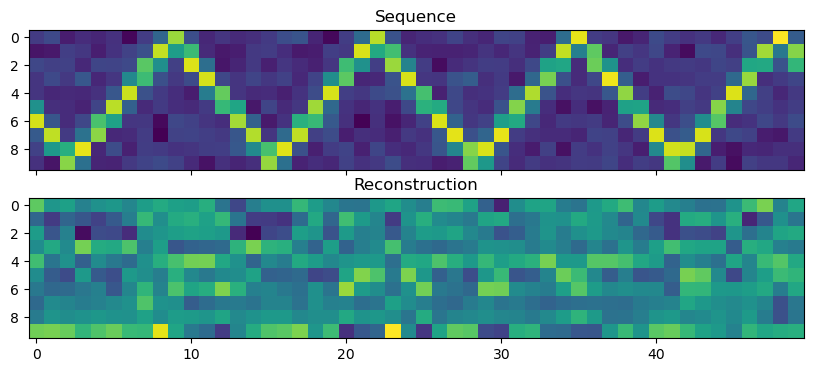

In [6]:
f, ax = plt.subplots(2, 1, figsize=(10, 4), sharex=True)
i = 6
viz_batch = process_batch(setup_batch)

ax[0].imshow(viz_batch[i].T, aspect='auto')
ax[0].set_title('Sequence')

_, loss, likelihood, _ = eval_step(state, viz_batch, N_data=512)
ax[1].imshow(likelihood.mean()[i].T, aspect='auto')
ax[1].set_title('Reconstruction')

print(loss)
plt.show()

`state.params` contains all the model parameters to be learned over time

In [7]:
state.params.keys()

frozen_dict_keys(['encoder', 'pgm', 'decoder'])

In [8]:
losses = []
epoch_losses = []
running_loss = 0.0

epoch_pbar = tqdm.trange(cfg.epochs)
for epoch in epoch_pbar:
    for batch in train_dataloader:
        batch = process_batch(batch)
        state, metrics = train_step(state, batch, N_data=N)

        running_loss = metrics['loss'].item() if running_loss == 0.0 else (running_loss * 0.9 + metrics['loss'].item() * 0.1)
        epoch_pbar.set_description("Loss: %.3f" % running_loss)
        epoch_losses.append(metrics['loss'].item())

    losses.append(np.mean(epoch_losses))

    if np.isnan(metrics['loss'].item()):
        break
        
    epoch_pbar.set_description("Loss: %.3f" % running_loss)

Loss: -675.142: 100%|██████████| 1000/1000 [07:03<00:00,  2.36it/s]


In [9]:
viz_batch = process_batch(next(iter(test_dataloader)))

total_loss = 0
for batch in test_dataloader:
    batch = process_batch(batch)
    state, loss, _, _ = eval_step(state, batch, N_data=512)
    total_loss += loss/batch.shape[-2]/batch.shape[-1] # in units of bpd

total_loss 

Array(-21.59627976, dtype=float64)

Now, we can plot a sequence and its reconstruction: both the mean of the reconstruction distribution, a sample from it, and the evolution of the latent variable $z$ over time

-675.1713056121467


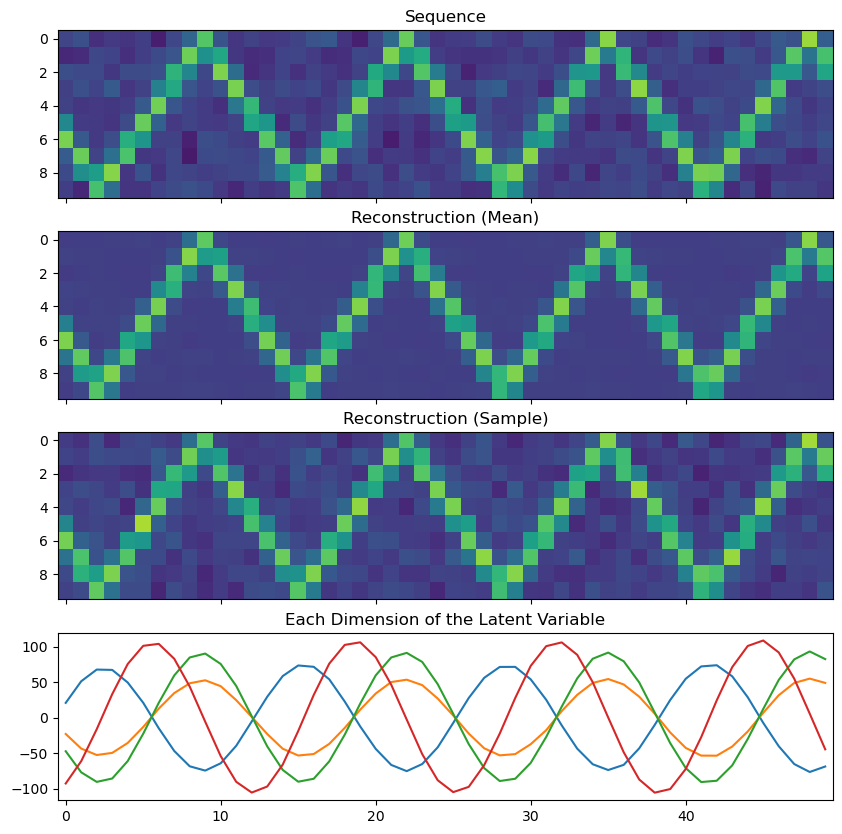

In [10]:
f, ax = plt.subplots(4, 1, figsize=(10, 10), sharex=True)
i = 6

ax[0].imshow(viz_batch[i].T, aspect='auto', vmin=-0.3, vmax=1.3)
ax[0].set_title('Sequence')

_, loss, likelihood, debug_metrics = eval_step(state, viz_batch, N_data=512)
ax[1].imshow(likelihood.mean()[i].T, aspect='auto', vmin=-0.3, vmax=1.3)
ax[1].set_title('Reconstruction (Mean)')

ax[2].imshow(likelihood.sample(seed=jax.random.PRNGKey(47))[i].T, aspect='auto', vmin=-0.3, vmax=1.3)
ax[2].set_title('Reconstruction (Sample)')

ax[3].plot(debug_metrics['aux'][0][i])
ax[3].set_title('Each Dimension of the Latent Variable')

print(loss)
plt.show()

What if we want to do imputation?

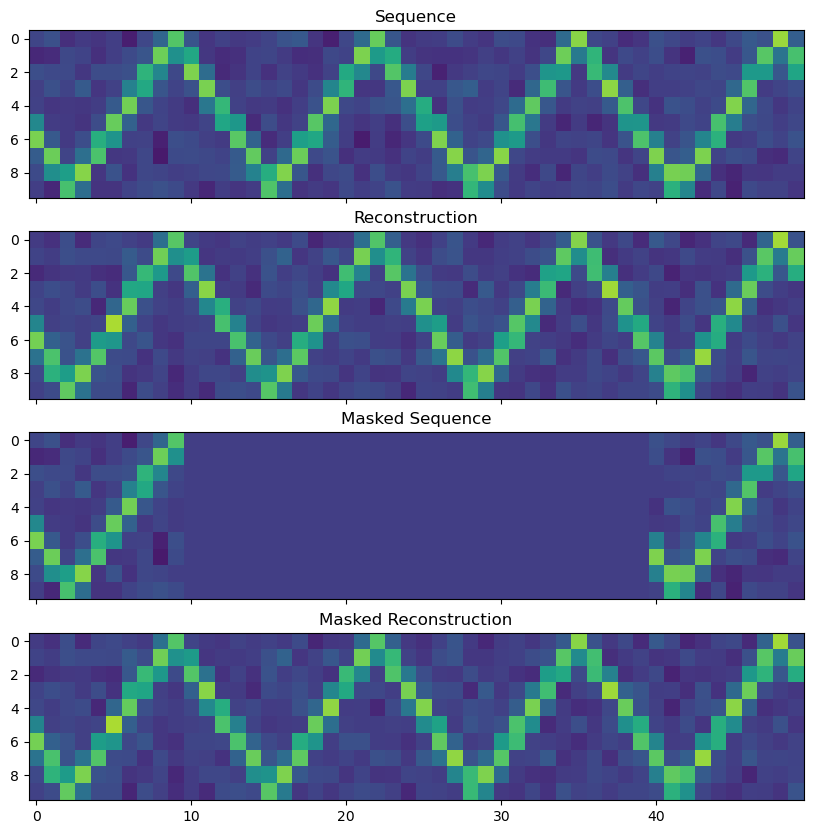

In [11]:
f, ax = plt.subplots(4, 1, figsize=(10, 10), sharex=True)
i = 6
viz_batch = process_batch(setup_batch)

ax[0].imshow(viz_batch[i].T, aspect='auto', vmin=-0.3, vmax=1.3)
ax[0].set_title('Sequence')

_, loss, likelihood, debug_metrics = eval_step(state, viz_batch, N_data=512)
ax[1].imshow(likelihood.sample(seed=jax.random.PRNGKey(47))[i].T, aspect='auto', vmin=-0.3, vmax=1.3)
ax[1].set_title('Reconstruction')

mask = jnp.ones_like(batch[...,0]).at[:,10:40].set(0).astype(bool)
masked_batch = viz_batch.at[:,10:40].set(0)

ax[2].imshow(masked_batch[i].T, aspect='auto', vmin=-0.3, vmax=1.3)
ax[2].set_title('Masked Sequence')

_, loss, likelihood, debug_metrics = eval_step(state, masked_batch, mask=mask, N_data=512)
ax[3].imshow(likelihood.sample(seed=jax.random.PRNGKey(47))[i].T, aspect='auto', vmin=-0.3, vmax=1.3)
ax[3].set_title('Masked Reconstruction')

plt.show()

It does an amazing job reconstructing the sequence given the beginning and endpoints!

In [8]:
os.makedirs("saved_models", exist_ok=True)
# save_state(state, 'saved_models/lds_sawtooth')

# you can load state with 
state = load_state(state, 'saved_models/lds_sawtooth')

Now let's escalate: we want discrete states, so we turn to the SVAE-SLDS. 

Trying to train an SVAE-SLDS from scratch comes with problems: it's easy for the discrete states to collapse at the beginning when it's trying to cluster random noise. This implies we should do a form of pretraining. Although initializing the encoder and decoder from the LDS is temping, this is ultimately counterproductive: the LDS, by definition, collapses the time series to a single modality of motion, as can be seen by how 'rounded' the latent variable is above. We'll fix this by pre-training a VAE, although we have to be careful: too much pretraining will 'lock-in' the mapping from observation to latent variable; we want to start SLDS training at a time when it can guide the latent variable's evolution to be linear, not try to fit linear dynamics to a latent space that has been already constructed to be non-linear.

In [9]:
from models.VAE import VAE
from train_utils import create_train_state 

warmup_model_builder = partial(VAE, latent_D=cfg.latent_D, input_D=setup_batch.shape[-1],
                               encoder_cls=encoder, decoder_cls=decoder)
warmup_model, warmup_state = create_train_state(cfg.init_rng, cfg.lr_net, warmup_model_builder, process_batch(setup_batch).shape)


Here, we use a `train_state` instead of a `dual_train_state`. This is because the VAE only has network parameters to be trained via Adam, instead of the SVAEs which need Adam training of the networks and SGD with natural gradient training of the graphical model.

In [14]:
cfg.warmup_epochs = 100
losses = []
epoch_losses = []
running_loss = 0.0

epoch_pbar = tqdm.trange(cfg.warmup_epochs)
for epoch in epoch_pbar:
    for batch in train_dataloader:
        batch = process_batch(batch)
        warmup_state, metrics = train_step(warmup_state, batch, N_data=N)

        running_loss = metrics['loss'].item() if running_loss == 0.0 else (running_loss * 0.9 + metrics['loss'].item() * 0.1)
        epoch_pbar.set_description("Loss: %.3f" % running_loss)
        epoch_losses.append(metrics['loss'].item())

    losses.append(np.mean(epoch_losses))

    if np.isnan(metrics['loss'].item()):
        break


Loss: 168.639: 100%|██████████| 100/100 [00:15<00:00,  6.54it/s]


In [10]:
# save_state(warmup_state, 'saved_models/vae_sawtooth')

# you can load state with 
warmup_state = load_state(warmup_state, 'saved_models/vae_sawtooth')

How is our reconstruction?

166.69658122268288


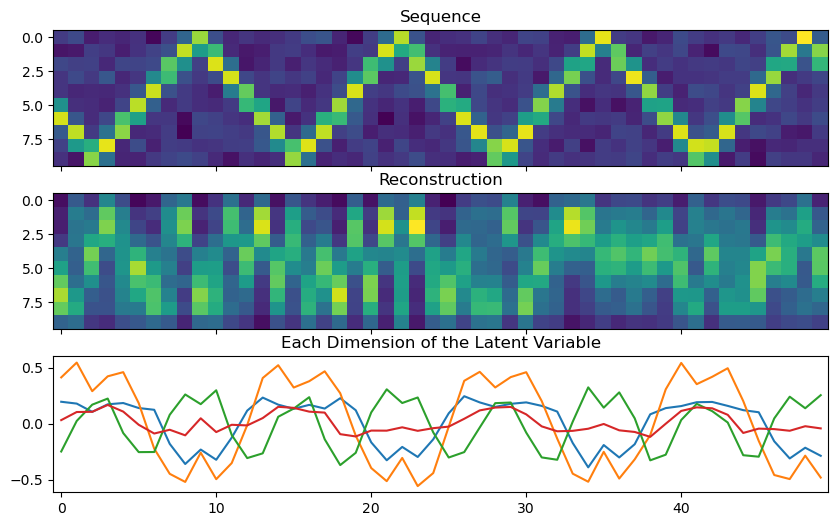

In [16]:
f, ax = plt.subplots(3, 1, figsize=(10, 6), sharex=True)
i = 6

ax[0].imshow(viz_batch[i].T, aspect='auto')
ax[0].set_title('Sequence')

_, loss, likelihood, debug_metrics = eval_step(warmup_state, viz_batch, N_data=512)
ax[1].imshow(likelihood.mean()[i].T, aspect='auto')
ax[1].set_title('Reconstruction')

ax[2].plot(debug_metrics['aux'].mean()[i])
ax[2].set_title('Each Dimension of the Latent Variable')

print(loss)
plt.show()

...very bad. But we can refine the encoder and decoder while also guiding the latent dynamics to be linear.

In [16]:
from models.SVAE_SLDS import SVAE_SLDS
cfg.K = 4

slds_model_builder = partial(SVAE_SLDS, latent_D=cfg.latent_D, K = cfg.K, input_D = setup_batch.shape[-1], 
                             encoder_cls=encoder, decoder_cls=decoder)
slds_model, slds_state = create_dual_train_state(cfg.init_rng, net_schedule, pgm_schedule, slds_model_builder, process_batch(setup_batch).shape, learning_alg_net=cfg.learning_alg_net, learning_alg_pgm=cfg.learning_alg_pgm)

# We can copy the encoder/decoder parameters from the VAE into the SLDS model
new_params = slds_state.params.copy({'encoder': warmup_state.params['encoder'], 
                                     'decoder': warmup_state.params['decoder']})
slds_state = slds_state.replace(params = new_params)

At initialization, the discrete states are very confused

308.5632600399118


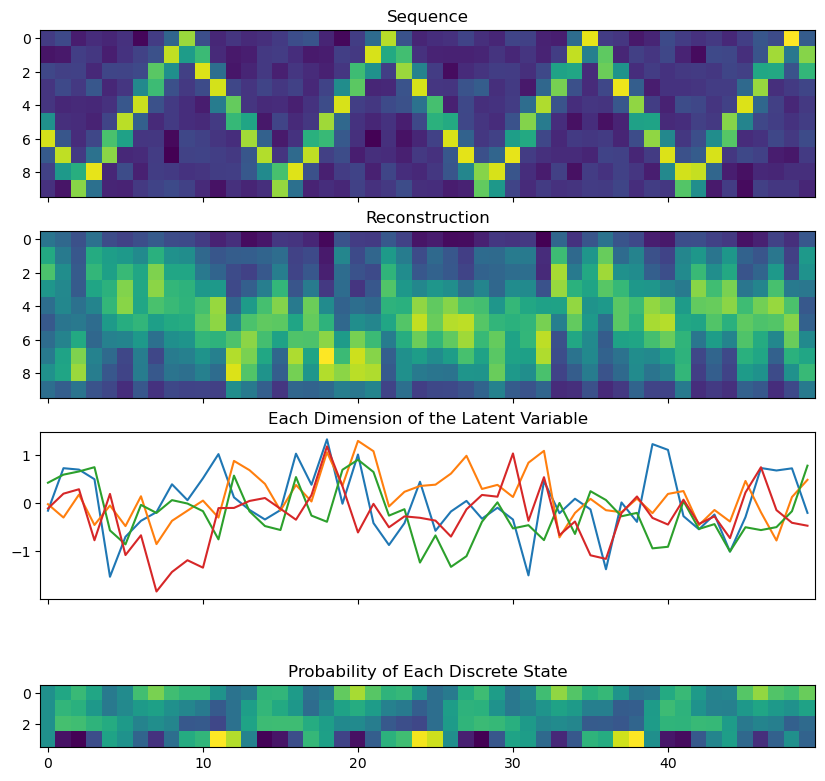

In [18]:
f, ax = plt.subplots(4, 1, figsize=(10, 10), sharex=True)
i = 6

ax[0].imshow(viz_batch[i].T, aspect='auto')
ax[0].set_title('Sequence')

_, loss, likelihood, debug_metrics = eval_step(slds_state, viz_batch, N_data=512)
ax[1].imshow(likelihood.mean()[i].T, aspect='auto')
ax[1].set_title('Reconstruction')

ax[2].plot(debug_metrics['aux'][0][i])
ax[2].set_title('Each Dimension of the Latent Variable')

cats = debug_metrics['aux'][-1][i]
padded_cats = jnp.concatenate([jnp.ones_like(cats[:1])/cfg.K, cats], 0)

ax[3].imshow(padded_cats.T)
ax[3].set_title('Probability of Each Discrete State')

print(loss)
plt.show()

In [19]:
cfg.slds_epochs = 200
losses = []
epoch_losses = []
running_loss = 0.0

epoch_pbar = tqdm.trange(cfg.slds_epochs)
for epoch in epoch_pbar:
    for batch in train_dataloader:
        batch = process_batch(batch)
        slds_state, metrics = train_step(slds_state, batch, N_data=N)

        running_loss = metrics['loss'].item() if running_loss == 0.0 else (running_loss * 0.9 + metrics['loss'].item() * 0.1)
        states_in_use = jnp.sum(metrics['aux'].mean(0).mean(0) > 0.1)

        epoch_pbar.set_description("Loss: %.3f, States in use: %d" % (running_loss, states_in_use))
        epoch_losses.append(metrics['loss'].item())

    losses.append(np.mean(epoch_losses))

    if np.isnan(metrics['loss'].item()):
        break

Loss: -540.543, States in use: 2: 100%|██████████| 200/200 [05:51<00:00,  1.76s/it]


In [20]:
total_loss = 0
for batch in test_dataloader:
    batch = process_batch(batch)
    slds_state, loss, _, _ = eval_step(slds_state, batch, N_data=512)
    total_loss += loss/batch.shape[-2]/batch.shape[-1] # in units of bpd

total_loss 

Array(-17.27706728, dtype=float64)

It's maybe unsurprising we don't get better loss with the SLDS than we do with the LDS. The motion is inherently a single modality; the SLDS's assumption that time spent in each state follows an exponential distribution is quite poor for this data

In [17]:
# save_state(slds_state, 'saved_models/slds_sawtooth')

# you can load state with 
slds_state = load_state(slds_state, 'saved_models/slds_sawtooth')

-541.4813456152353


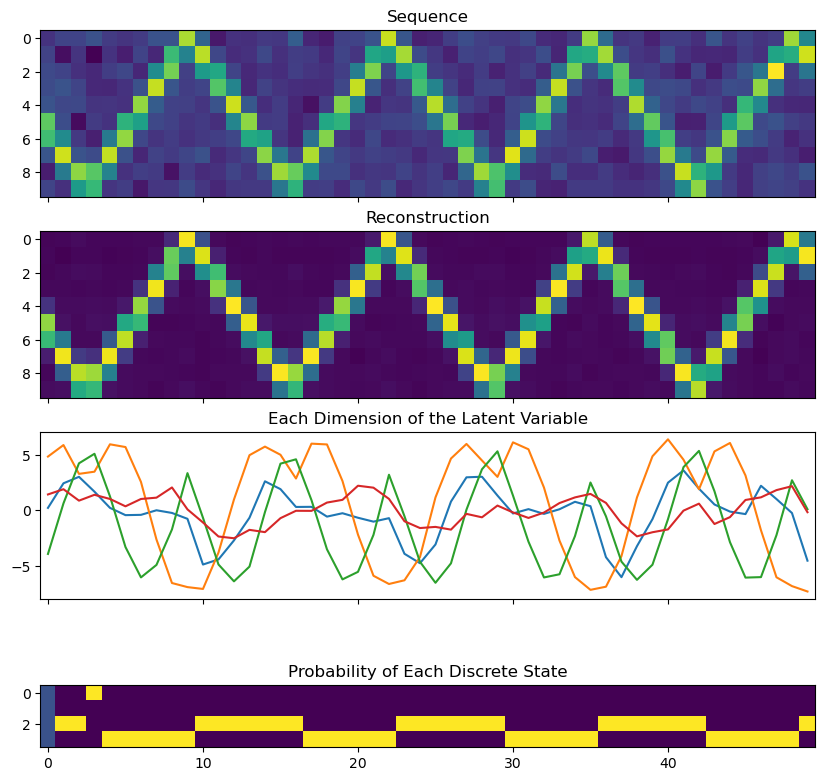

In [22]:
f, ax = plt.subplots(4, 1, figsize=(10, 10), sharex=True)
i = 5

ax[0].imshow(viz_batch[i].T, aspect='auto')
ax[0].set_title('Sequence')

_, loss, likelihood, debug_metrics = eval_step(slds_state, viz_batch, N_data=512)
ax[1].imshow(likelihood.mean()[i].T, aspect='auto')
ax[1].set_title('Reconstruction')

ax[2].plot(debug_metrics['aux'][0][i])
ax[2].set_title('Each Dimension of the Latent Variable')

cats = debug_metrics['aux'][-1][i]
padded_cats = jnp.concatenate([jnp.ones_like(cats[:1])/cfg.K, cats], 0)

ax[3].imshow(padded_cats.T)
ax[3].set_title('Probability of Each Discrete State')

print(loss)
plt.show()

The SLDS is actually not a great model for this data; one might think it could be well-modeled by two states, but the Markovian assumption on the discrete latent variable doesn't well fit the data, where it spends an exact amount of time in both modalities. Instead, the model recovers the cyclic nature present in the data, and uses discrete states for varying levels of uncertainty in each next-step evolution

#### SEMI MARKOV

In [47]:
from models.SVAE_SMSLDS import SVAE_SMSLDS

sm_model_builder = partial(SVAE_SMSLDS, latent_D=cfg.latent_D, K = cfg.K, input_D = setup_batch.shape[-1], 
                           encoder_cls=encoder, decoder_cls=decoder)
sm_model, sm_state = create_dual_train_state(cfg.init_rng, net_schedule, pgm_schedule, sm_model_builder, process_batch(setup_batch).shape, learning_alg_net=cfg.learning_alg_net, learning_alg_pgm=cfg.learning_alg_pgm)

new_alpha = slds_state.params['pgm']['alpha'][(1-np.identity(cfg.K)).astype(bool)].reshape((cfg.K,cfg.K-1))
new_dur_n = jnp.zeros_like(sm_state.params['pgm']['dur_n'])#.at[:,-1].set(10)
new_pgm = sm_state.params['pgm'].copy(slds_state.params['pgm']).copy({'alpha': new_alpha, 'dur_n': new_dur_n})

# We can copy the encoder/decoder parameters from the VAE into the SLDS model
new_params = sm_state.params.copy({'encoder': slds_state.params['encoder'], 
                                   'decoder': slds_state.params['decoder'],
                                   'pgm': new_pgm})
sm_state = sm_state.replace(params = new_params)

146.42678824914321


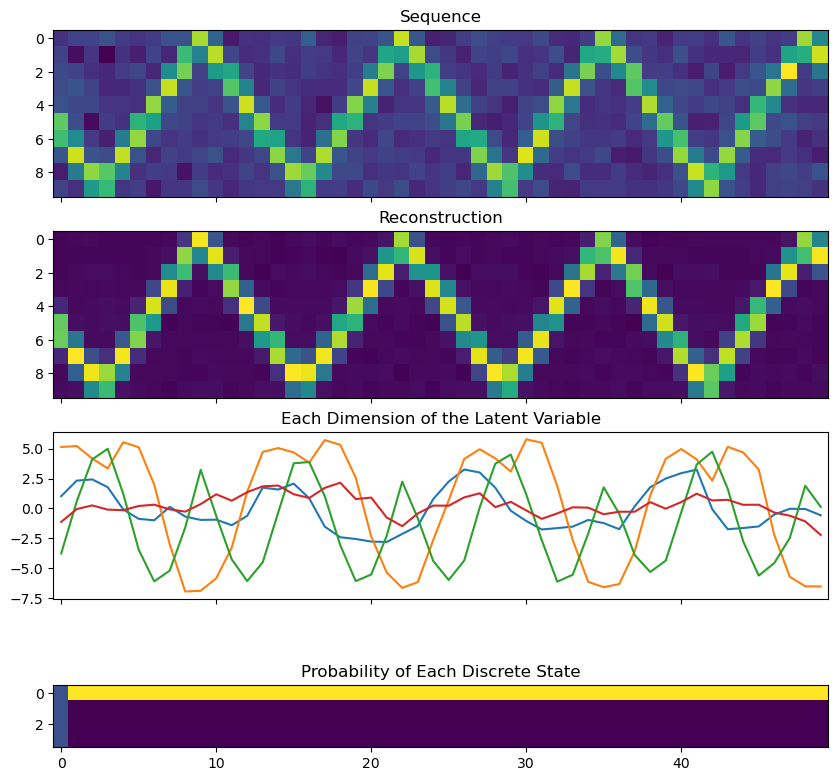

In [49]:
f, ax = plt.subplots(4, 1, figsize=(10, 10), sharex=True)
i = 5

ax[0].imshow(viz_batch[i].T, aspect='auto')
ax[0].set_title('Sequence')

_, loss, likelihood, debug_metrics = eval_step(sm_state, viz_batch, N_data=512)
ax[1].imshow(likelihood.mean()[i].T, aspect='auto')
ax[1].set_title('Reconstruction')

ax[2].plot(debug_metrics['aux'][0][i])
ax[2].set_title('Each Dimension of the Latent Variable')

cats = debug_metrics['aux'][-1][i]
padded_cats = jnp.concatenate([jnp.ones_like(cats[:1])/cfg.K, cats], 0)

ax[3].imshow(padded_cats.T)
ax[3].set_title('Probability of Each Discrete State')

print(loss)
plt.show()

In [40]:
cfg.sm_epochs = 200
losses = []
epoch_losses = []
running_loss = 0.0

epoch_pbar = tqdm.trange(cfg.sm_epochs)
for epoch in epoch_pbar:
    for batch in train_dataloader:
        batch = process_batch(batch)
        sm_state, metrics = train_step(sm_state, batch, N_data=N)

        running_loss = metrics['loss'].item() if running_loss == 0.0 else (running_loss * 0.9 + metrics['loss'].item() * 0.1)
        states_in_use = jnp.sum(metrics['aux'].mean(0).mean(0) > 0.1)

        epoch_pbar.set_description("Loss: %.3f, States in use: %d" % (running_loss, states_in_use))
        epoch_losses.append(metrics['loss'].item())

    losses.append(np.mean(epoch_losses))

    if np.isnan(metrics['loss'].item()):
        break

Loss: -513.461, States in use: 2:  50%|█████     | 100/200 [06:07<06:07,  3.67s/it]


KeyboardInterrupt: 

-520.7721354753872


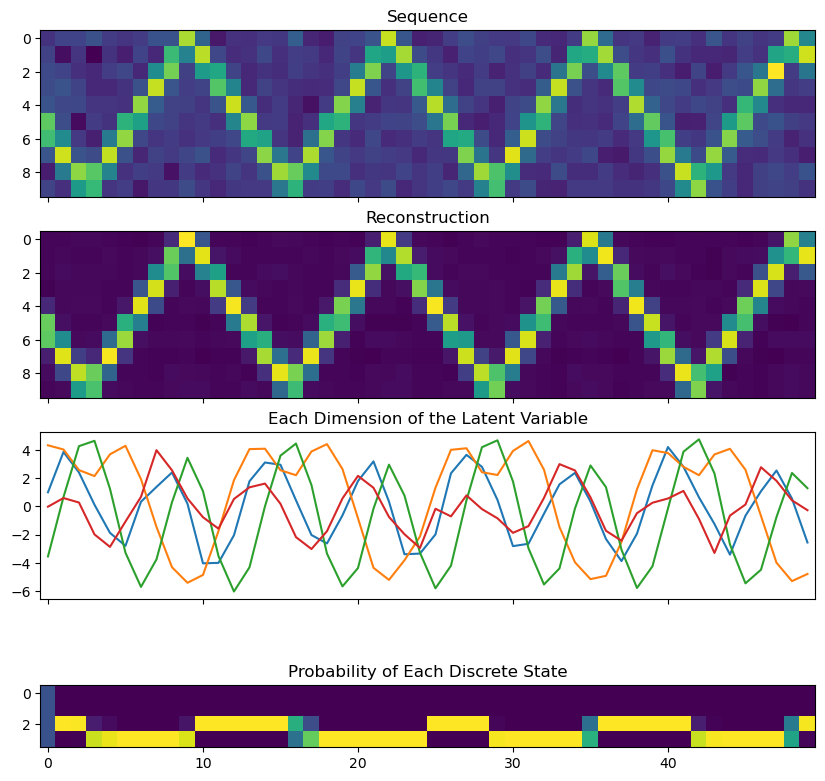

In [41]:
f, ax = plt.subplots(4, 1, figsize=(10, 10), sharex=True)
i = 5

ax[0].imshow(viz_batch[i].T, aspect='auto')
ax[0].set_title('Sequence')

_, loss, likelihood, debug_metrics = eval_step(sm_state, viz_batch, N_data=512)
ax[1].imshow(likelihood.mean()[i].T, aspect='auto')
ax[1].set_title('Reconstruction')

ax[2].plot(debug_metrics['aux'][0][i])
ax[2].set_title('Each Dimension of the Latent Variable')

cats = debug_metrics['aux'][-1][i]
padded_cats = jnp.concatenate([jnp.ones_like(cats[:1])/cfg.K, cats], 0)

ax[3].imshow(padded_cats.T)
ax[3].set_title('Probability of Each Discrete State')

print(loss)
plt.show()

#### New synthetic data

To play around with data for which the SLDS is correctly specified, see the generating code below. We show results on this data in our appendix

In [23]:
from flax.linen import softplus
make_renderer = lambda grid: lambda mu, sigma: jnp.sqrt(sigma+1) * np.exp(-1./2 * jnp.abs(grid - mu)/sigma)

def stay_in_cluster(state):
    if state == 0:
        return 1
    elif state == 1:
        return 0
    elif state == 2:
        return 3
    else:
        return 2

def change_cluster(state, cond):
    if (state < 2) and cond:
        return 3
    elif state < 2:
        return 2
    elif cond:
        return 1
    else:
        return 0

def make_switching_data(image_width, num_steps, rng, transition_p = 0.1,
                        stay_in_cluster_p = 0.9, sigma_offset = 0.1, 
                        sigma_offset_noise = 0.01, mu_offset = 0.03, 
                        mu_offset_noise = 0.004, noise_sigma = 0.02):
    grid = np.linspace(-2, 2, image_width, endpoint=True)
    render = make_renderer(grid)

    state = 0
    step = 0
    delta_states = []
    lengths = []
    while step < num_steps:
        length = rng.geometric(transition_p)
        lengths.append(length)
        if rng.binomial(1, stay_in_cluster_p):
            new_state = stay_in_cluster(state)
        else:
            new_state = change_cluster(state, rng.binomial(1,0.5))
        delta_states.append(new_state - state)
        state = new_state
        step = step + length

    state = jnp.cumsum(jnp.zeros(num_steps).at[jnp.cumsum(jnp.array(lengths))].set(delta_states)) % 4

    delta_sigma = (rng.standard_normal(num_steps) * sigma_offset_noise + sigma_offset)
    delta_mu = (rng.standard_normal(num_steps) * mu_offset_noise + mu_offset)
    adj_delta_sigma = jnp.array(delta_sigma).at[state < 2].set(0).at[state == 2].set(-delta_sigma[state ==2])
    adj_delta_mu = jnp.array(delta_mu).at[state >= 2].set(0).at[state == 1].set(-delta_mu[state==1])
    mus = jnp.cumsum(adj_delta_mu)
    sigmas = softplus(jnp.cumsum(adj_delta_sigma )- 1)

    im = jnp.stack([render(mu, sigma) for mu, sigma in zip(mus, sigmas)])
    T = state.shape[0] - 1
    switch = jnp.zeros((T, 4)).at[jnp.arange(T), state[1:].astype(jnp.int32)].set(1)
    return im + noise_sigma * rng.standard_normal(im.shape), switch, sigmas, mus

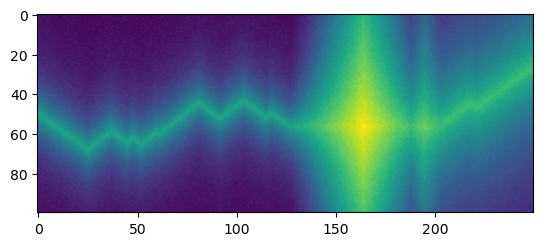

In [24]:
rng = np.random.default_rng(47)
im, _, _, _ = make_switching_data(100, 250, rng)
plt.imshow(im.T)
plt.show()

### State binding

If you want to debug your model in an interactive manner, so that you can investigate the output of the encoder, the output of the PGM etc. you can do so via `bind_state`

In [25]:
from train_utils import bind_state
svae_slds = bind_state(slds_model, slds_state)

If you want to perfectly recover the results of `eval_step` in this interactive session, you can do so as well; however, we need to add a step at the beginning. `eval_step` begins by updating the `rng_state` of the state object; this is necessary because any rng calls made within the forward pass do not update the state's random keys (because Jax/Flax requires our functions to be pure). Thus we first update the rng keys as `eval_step` would do, and work from there:

In [26]:
temp_state = slds_state.replace(rng_state = jax.tree_map(lambda r: jax.random.split(r)[1], slds_state.rng_state))
svae_slds = bind_state(slds_model, temp_state)

In [27]:
x = viz_batch

recog_potentials = svae_slds.encoder(x)
key = jax.random.split(svae_slds.make_rng('sampler'),x.shape[0])
keys = jax.vmap(jax.random.split)(key)
key, initializer = keys[:,0], keys[:,1]

with jax.default_matmul_precision('float32'):
    pgm_outputs = jax.vmap(svae_slds.pgm)(recog_potentials, key, initializer)
    pgm_params = svae_slds.pgm.expected_params()

likelihood = svae_slds.decoder(pgm_outputs[0].astype(jnp.float32))

In [28]:
errors = eval_step(slds_state, viz_batch, N_data=512)[2].mean() - likelihood.mean()

print(jnp.mean(jnp.abs(errors)))

8.174684e-09


(there are actually some non-zero components hidden in there, caused by `jit` compilation changing the order in which operations are performed. This leads to rounding errors)